# Reducing ICESat-2 data files


University of Washington ICESat-2 Hackweek | June 2019 <br>
originally written by Fernando Paulo @fspaolo <br>
adjusted for #glaciersat2 by Caitlyn Florentine @cflorentine <br>

---
## Workflow
  1. Inspect input files
  2. Build simple data reader functions
  3. Reduce selected files with variables of interest
  2. Convert files from .h5 to .csv format

## 1. Inspect input files

Set up the correct working directory and check out the input files.

In [46]:
!cd /home/jovyan/glaciersat2/data-access

In [51]:
def list_files_local(path):
    """ Get file list form local folder. """
    from glob import glob
    return glob(path)

files = list_files_local('notebooks/Outputs/*_01.h5')

for f in files:
    print(f)
print('Total number of files:', len(files))

notebooks/Outputs/ATL06_20181115223845_07380102_001_01.h5
notebooks/Outputs/ATL06_20190208070823_06390206_001_01.h5
notebooks/Outputs/ATL06_20181014001049_02350102_001_01.h5
notebooks/Outputs/ATL06_20190210182651_06770202_001_01.h5
notebooks/Outputs/ATL06_20181109112837_06390106_001_01.h5
notebooks/Outputs/ATL06_20181111224708_06770102_001_01.h5
notebooks/Outputs/ATL06_20181212095603_11420106_001_01.h5
notebooks/Outputs/ATL06_20190214181831_07380202_001_01.h5
notebooks/Outputs/ATL06_20181214211434_11800102_001_01.h5
Total number of files: 9




Let's check out all of the information stored within the .h5 file:

**TIP** *: This will generate a big long cell showing an exhaustive list of all ATL06 ICESat-2 variables. You can collapse the big long cell by clicking on the blue side bar on the left side of the cell.*

In [55]:
example = files[1]
!h5ls -r {example}

/                        Group
/METADATA                Group
/METADATA/AcquisitionInformation Group
/METADATA/AcquisitionInformation/lidar Group
/METADATA/AcquisitionInformation/lidarDocument Group
/METADATA/AcquisitionInformation/platform Group
/METADATA/AcquisitionInformation/platformDocument Group
/METADATA/DataQuality    Group
/METADATA/DataQuality/CompletenessOmission Group
/METADATA/DataQuality/DomainConsistency Group
/METADATA/DatasetIdentification Group
/METADATA/Extent         Group
/METADATA/Lineage        Group
/METADATA/Lineage/ANC06-01 Group
/METADATA/Lineage/ANC06-02 Group
/METADATA/Lineage/ANC06-03 Group
/METADATA/Lineage/ANC17  Group
/METADATA/Lineage/ANC19  Group
/METADATA/Lineage/ANC25-06 Group
/METADATA/Lineage/ANC26-06 Group
/METADATA/Lineage/ANC28  Group
/METADATA/Lineage/ANC36-06 Group
/METADATA/Lineage/ANC38-06 Group
/METADATA/Lineage/ATL03  Group
/METADATA/Lineage/ATL09  Group
/METADATA/Lineage/Control Group
/METADATA/ProcessStep    Group
/METADATA/ProcessStep/

## 2. Build data reduction functions

Let's code a simple reader that:

- Selects variables of interest (x, y, t, h...)  
- Filters data points based on quality flag and bbox   
- Separates into beams and ascending/descending tracks  
- Saves data to a simpler HDF5 structure (redundancy/efficiency)

First we need to build some utility funtions:

In [34]:
import pyproj
from astropy.time import Time

def gps2dyr(time): # figure out where (when) data are in time
    """ Converte GPS time to decimal years. """
    return Time(time, format='gps').decimalyear


def track_type(time, lat, tmax=1):
    """
    Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    i_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  i_asc[i_track] = True
    
    return i_asc, np.invert(i_asc)  # index vectors


def transform_coord(proj1, proj2, x, y):
    """
    Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projs:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


Now we build the simple reader to pluck the bare bones variables of interest:

In [35]:
import h5py 
import numpy as np

def read_atl06(fname, bbox=None):
    """ 
    Read 1 ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']

    # Loop trough beams
    for k,g in enumerate(group):
    
        #-----------------------------------#
        # 1) Read in data for a single beam #
        #-----------------------------------#
    
        # Load variables into memory (more can be added!)
        with h5py.File(fname, 'r') as fi:
            lat = fi[g+'/land_ice_segments/latitude'][:]
            lon = fi[g+'/land_ice_segments/longitude'][:]
            h_li = fi[g+'/land_ice_segments/h_li'][:]
            s_li = fi[g+'/land_ice_segments/h_li_sigma'][:]
            t_dt = fi[g+'/land_ice_segments/delta_time'][:]
            q_flag = fi[g+'/land_ice_segments/atl06_quality_summary'][:]
            s_fg = fi[g+'/land_ice_segments/fit_statistics/signal_selection_source'][:]
            snr = fi[g+'/land_ice_segments/fit_statistics/snr_significance'][:]
            h_rb = fi[g+'/land_ice_segments/fit_statistics/h_robust_sprd'][:]
            dac = fi[g+'/land_ice_segments/geophysical/dac'][:]
            f_sn = fi[g+'/land_ice_segments/geophysical/bsnow_conf'][:]
            dh_fit_dx = fi[g+'/land_ice_segments/fit_statistics/dh_fit_dx'][:]
            tide_earth = fi[g+'/land_ice_segments/geophysical/tide_earth'][:]
            tide_load = fi[g+'/land_ice_segments/geophysical/tide_load'][:]
            tide_ocean = fi[g+'/land_ice_segments/geophysical/tide_ocean'][:]
            tide_pole = fi[g+'/land_ice_segments/geophysical/tide_pole'][:]
            t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]
            rgt = fi['/orbit_info/rgt'][:] * np.ones(len(lat))
            orb = np.full_like(h_li, k)

        #---------------------------------------------#
        # 2) Filter data according region and quality #
        #---------------------------------------------#
        
        # Select a region of interest
        if bbox:
            lonmin, lonmax, latmin, latmax = bbox
            bbox_mask = (lon >= lonmin) & (lon <= lonmax) & \
                        (lat >= latmin) & (lat <= latmax)
        else:
            bbox_mask = np.ones_like(lat, dtype=bool)  # get all
            
        # Only keep good data, and data inside bbox
        mask = (q_flag == 0) & (np.abs(h_li) < 10e3) & (bbox_mask == 1) #cf grab only quality data, limit  height of data, +bbox, all combined into one mask
        
        # Update variables
        lat, lon, h_li, s_li, t_dt, h_rb, s_fg, snr, q_flag, f_sn, \
            tide_earth, tide_load, tide_ocean, tide_pole, dac, rgt, orb = \
                lat[mask], lon[mask], h_li[mask], s_li[mask], t_dt[mask], \
                h_rb[mask], s_fg[mask], snr[mask], q_flag[mask], f_sn[mask], \
                tide_earth[mask], tide_load[mask], tide_ocean[mask], \
                tide_pole[mask], dac[mask], rgt[mask], orb[mask]

        # Test for no data
        if len(h_li) == 0: continue

        #-------------------------------------#
        # 3) Convert time and separate tracks #
        #-------------------------------------#
        
        # Time in GPS seconds (secs sinde 1980...)
        t_gps = t_ref + t_dt

        # Time in decimal years
        t_year = gps2dyr(t_gps)

        # Determine orbit type
        i_asc, i_des = track_type(t_year, lat)
        
        #-----------------------#
        # 4) Save selected data #
        #-----------------------#
        
        # Define output file name
        ofile = fname.replace('.h5', '_'+g[1:]+'.h5') #cf add the beam identification (i.e. ground track, left/right, etc.)
                
        # Save variables
        with h5py.File(ofile, 'w') as f:
            f['orbit'] = orb
            f['lon'] = lon
            f['lat'] = lat
            f['h_elv'] = h_li
            f['t_year'] = t_year
            f['t_sec'] = t_gps
            f['s_elv'] = s_li
            f['h_rb'] = h_rb
            f['s_fg'] = s_fg
            f['snr'] = snr
            f['q_flg'] = q_flag
            f['f_sn'] = f_sn
            f['tide_load'] = tide_load
            f['tide_ocean'] = tide_ocean
            f['tide_pole'] = tide_pole
            f['tide_earth'] = tide_earth
            f['dac'] = dac
            f['rgt'] = rgt
            f['trk_type'] = i_asc

            print('out ->', ofile)
                

## 3. Reduce files
Now we will put the functions to work to produce reduced files:

In [56]:
bbox = None
for f in files:
    read_atl06(f,bbox)

out -> notebooks/Outputs/ATL06_20181115223845_07380102_001_01_gt1l.h5
out -> notebooks/Outputs/ATL06_20181115223845_07380102_001_01_gt1r.h5
out -> notebooks/Outputs/ATL06_20181115223845_07380102_001_01_gt2l.h5
out -> notebooks/Outputs/ATL06_20181115223845_07380102_001_01_gt2r.h5
out -> notebooks/Outputs/ATL06_20181115223845_07380102_001_01_gt3l.h5
out -> notebooks/Outputs/ATL06_20181115223845_07380102_001_01_gt3r.h5
out -> notebooks/Outputs/ATL06_20190208070823_06390206_001_01_gt1l.h5
out -> notebooks/Outputs/ATL06_20190208070823_06390206_001_01_gt1r.h5
out -> notebooks/Outputs/ATL06_20190208070823_06390206_001_01_gt2l.h5
out -> notebooks/Outputs/ATL06_20190208070823_06390206_001_01_gt2r.h5
out -> notebooks/Outputs/ATL06_20190208070823_06390206_001_01_gt3l.h5
out -> notebooks/Outputs/ATL06_20190208070823_06390206_001_01_gt3r.h5
out -> notebooks/Outputs/ATL06_20181014001049_02350102_001_01_gt1l.h5
out -> notebooks/Outputs/ATL06_20181014001049_02350102_001_01_gt1r.h5
out -> notebooks/Out

Take a look at the reduced files:

In [58]:
reduced_files = list_files_local('notebooks/Outputs/*_01_gt*.h5')
example = reduced_files[1]
!h5ls -r {example}

/                        Group
/dac                     Dataset {2272}
/f_sn                    Dataset {2272}
/h_elv                   Dataset {2272}
/h_rb                    Dataset {2272}
/lat                     Dataset {2272}
/lon                     Dataset {2272}
/orbit                   Dataset {2272}
/q_flg                   Dataset {2272}
/rgt                     Dataset {2272}
/s_elv                   Dataset {2272}
/s_fg                    Dataset {2272}
/snr                     Dataset {2272}
/t_sec                   Dataset {2272}
/t_year                  Dataset {2272}
/tide_earth              Dataset {2272}
/tide_load               Dataset {2272}
/tide_ocean              Dataset {2272}
/tide_pole               Dataset {2272}
/trk_type                Dataset {2272}


Phew! Much simpler.

## 4. Convert files from .h5 to .csv

In [253]:
d = pd.HDFStore(example,'r')
d.append('store_key', df, data_columns=['int32','int64','string'])
e = store.get_storer('store_key').table
f = store.get_storer('store_key').table.colindexes
print(e)
# print(d.get())
# print(d)
# x = d.get_storer('store_key')
# print(x)

NameError: name 'df' is not defined

In [240]:
import pandas as pd
 
with pd.HDFStore(example, 'r') as d:
    df = d.get('TheData')
    df.to_csv('myfile.csv')

KeyError: 'No object named TheData in the file'

In [235]:
example[20:-2]
print(example)

data-access-outputs/ATL06_20190222031203_08500210_001_01_gt1r.h5


In [ ]:
# Create folder for storing csv output files
!mkdir csv-outputs 

In [231]:
import numpy as np
import h5py
csvfilename = '/csv-outputs/' + example[20:-3] + '.csv'
filename = str(reduced_files[0])
np.savetxt(csvfilename, h5py.File(filename), '%g', ',')

FileNotFoundError: [Errno 2] No such file or directory: '/csv-outputs/ATL06_20190222031203_08500210_001_01_gt1r.csv'

In [230]:
h5py.File(example[20:-3])

<HDF5 file "ATL06_20190222031203_08500210_001_01_gt1r" (mode r+)>

In [ ]:
file = h5py.File('model.h5','r+')

dataset1 = file['/dense_1/dense_1/kernel'] // suppose kernel contains the weights
numpy.savetxt("dataset1.csv",dataset1)

In [224]:
csvfilename

'/csv-outputs/data-access-outputs/ATL06_20190222031203_08500210_001_01_gt1r.csv'

In [215]:
example[0:-3]
print(reduced_files[0])

data-access-outputs/ATL06_20190222031944_08500211_001_01_gt2l.h5


In [204]:
import pandas as pd
pd.HDFStore(example,'r')

ImportError: HDFStore requires PyTables, "No module named 'tables'" problem importing

In [203]:
# convert reduced .h5 files to .csv
import pandas as pd
# path_to_file = './'
# for f in files:
with pd.HDFStore(example, 'r') as ex:
    df = ex.get('ex')
    df.to_csv('path/csv_files/ex.csv')

ImportError: HDFStore requires PyTables, "No module named 'tables'" problem importing

In [202]:
print(path)

/home/jovyan/glaciersat2/data-access/data-access-subsetted-outputs/


In [196]:
print(example)

data-access-outputs/ATL06_20190222031203_08500210_001_01_gt1r.h5


/srv/conda/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


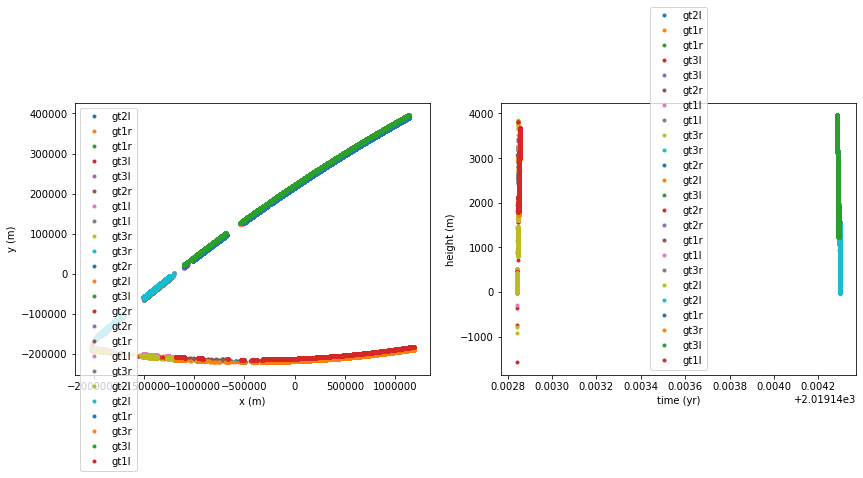

In [146]:
import matplotlib.pyplot as plt

def read_h5(fname, vnames=[]): #cf read files
    """ Simple HDF5 reader. """
    with h5py.File(fname, 'r') as f:
        return [f[v][:] for v in vnames]

    
# files = list_files_local('data/ATL06_20190101002504_00540211_209_01_gt*')

files = list_files_local('data-access-outputs/*_01_gt*.h5')

fig = plt.figure(figsize=(14,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for fname in files:

    lon, lat, t, h = read_h5(fname, ['lon', 'lat', 't_year', 'h_elv'])
    
    x, y = transform_coord(4326, 3031, lon, lat)
 
    ax1.plot(x, y, '.', label='%s' % fname[-7:-3])
    ax2.plot(t, h, '.', label='%s' % fname[-7:-3])
    
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.legend()
ax2.set_xlabel('time (yr)')
ax2.set_ylabel('height (m)')
ax2.legend()
plt.show()
    

## Single program from the command line

You can put all of the above (and more) into a single script and run it on the command line:

In [42]:
!python readatl06.py -h

usage: readatl06.py [-h] [-o odir] [-f fmask] [-b w e s n] [-n njobs]
                    [-p epsg_num] [-i index] [-g gran [gran ...]]
                    ifile [ifile ...]

Program for reading ICESat ATL06 data.

positional arguments:
  ifile               path for ifile(s) to read (.h5)

optional arguments:
  -h, --help          show this help message and exit
  -o odir             path to output folder
  -f fmask            name of raster file mask
  -b w e s n          bounding box for geographical region (deg)
  -n njobs            number of cores to use for parallel processing
  -p epsg_num         projection: EPSG number (AnIS=3031, GrIS=3413)
  -i index            provide mission index
  -g gran [gran ...]  only select specific granule(s)


Try reading the ICESat-2 files in parallel from the command line:

## Review
In this workflow we have:

* inspected raw hdf5 ICESat-2 ATL06 files
* built simple data reader and data reduction functions
* reduced .h5 files to contain only variables of interest (x,y,z..)
* converted files from .h5 to .csv format

Please refer to the original version of this tutorial for more information including how to embaressingly parallel data reduction.

## Appendix A: ICESat-2 file naming convention 

File naming convention:

`ATL06_[yyyymmdd][hhmmss]_[RGTccss]_[vvv_rr].h5`

where

`ATL_06` => L3A Land Ice product    

`yyyymmdd` => Year, month, day of data acquisition    

`hhmmss` => Hour, minute, second of data acquisition   

`RGT` => Reference Ground Track    

`cc` => Cycle Number   

`ss` => Segment number (latitude band)   

`vvv_rr` => Version and revision numbers  

## Appendix B: Other useful bits of code

To make it easier to grab information about the ICESat-2 .h5 files, you can create variables that capture parsed information from the file.

For example, after running this next cell YY becomes data year.

In [61]:
# Create compiled regular extraction object
# originally coded by Tyler Sutterley
import re
rx = re.compile('(processed_)?(ATL\d{2})_(\d{4})(\d{2})(\d{2})(\d{2})'
	'(\d{2})(\d{2})_(\d{4})(\d{2})(\d{2})_(\d{3})_(\d{2})(.*?).h5$')
SUB,PRD,YY,MM,DD,HH,MN,SS,TRK,CYCL,GRAN,RL,VERS,AUX = rx.findall(f).pop()

In [ ]:
# Say you need to parse a filepath string on the / character
# two = os.path.split(example)